In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-uci/heart.csv


# Heart Disease Classification

## Aim:
Predict heart disease in patients with an accuracy >= 90%

## Dataset Details
The original database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4

## Feature Details:    
1. age - age in years

2. sex - (1 = male; 0 = female)

3. cp - chest pain type <br>
0: Typical angina: chest pain related decrease blood supply to the heart <br>
1: Atypical angina: chest pain not related to heart<br>
2: Non-anginal pain: typically esophageal spasms (non heart related)<br>
3: Asymptomatic: chest pain not showing signs of disease<br>

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern

5. chol - serum cholestoral in mg/dl serum = LDL + HDL + .2 * triglycerides above 200 is cause for concern

6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) '>126' mg/dL signals diabetes

7. restecg - resting electrocardiographic results <br>
0: Nothing to note<br>
1: ST-T Wave abnormality can range from mild symptoms to severe problems signals non-normal heart beat<br>
2: Possible or definite left ventricular hypertrophy Enlarged heart's main pumping chamber<br>
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
12. ca - <br>
0: Upsloping: better heart rate with excercise (uncommon) <br>
1: Flatsloping: minimal change (typical healthy heart) <br>
2: Downslopins: signs of unhealthy heart number of major vessels (0-3) colored by flourosopy colored vessel means the doctor can see the blood passing through the more blood movement the better (no clots) <br>
13. thal - thalium stress result <br>
1,3: normal <br>
6: fixed defect: used to be defect but ok now<br>
7: reversable defect: no proper blood movement when excercising <br>
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)
    
https://www.kaggle.com/ronitf/heart-disease-uci

## Importing Libraies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")
sns.set(font_scale = 1.5) 

%matplotlib inline

import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import mean_squared_error


## Import Dataset

In [3]:
heart_df = pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")
heart_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


From the looking at the details of the table there appears to be no missing variables in the dataset.

## Exploritory Data Analysis (EDA)

In [6]:
#Checking the target column
heart_df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [7]:
heart_df.target.value_counts(normalize = True)

1    0.544554
0    0.455446
Name: target, dtype: float64

Having a visual look at some of the features

Text(0.5, 0, '1 = Heart Disease, 0 = No Heart Disease')

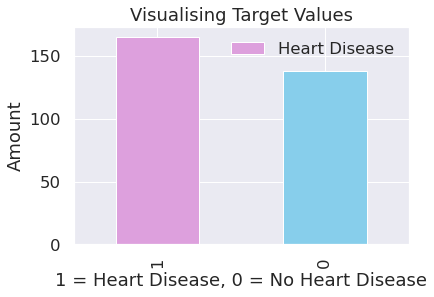

In [8]:
#Visualising Target Values
heart_df.target.value_counts().plot(kind = "bar", color = ["plum", "skyblue"])
plt.legend(["Heart Disease", "No Heart Disease"])
plt.title("Visualising Target Values")
plt.ylabel("Amount")
plt.xlabel("1 = Heart Disease, 0 = No Heart Disease")

Text(0.5, 0, '1 = Male, 0 = Female')

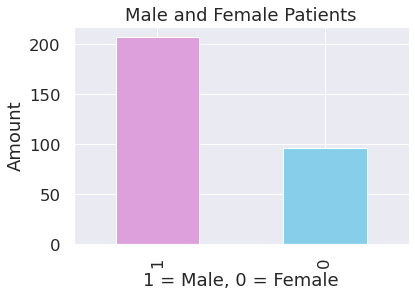

In [9]:
# Visualising Male and Female Patients
heart_df.sex.value_counts().plot(kind = "bar", color = ["plum", "skyblue"])
plt.title("Male and Female Patients")
plt.ylabel("Amount")
plt.xlabel("1 = Male, 0 = Female")

Text(0.5, 0, '0 = No Heart Disease, 1 = Heart Disease ')

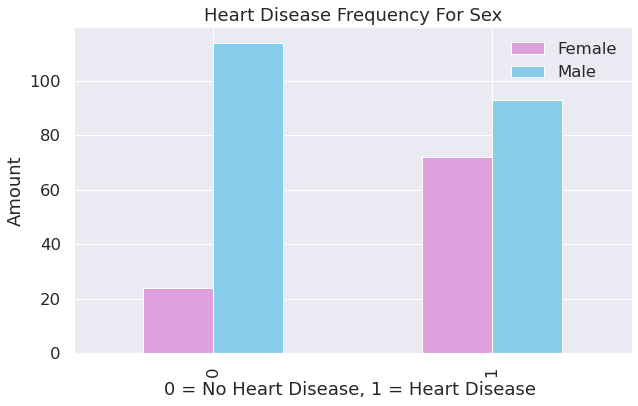

In [10]:
# Visualising Heart Disease Frequency For Sex
pd.crosstab(heart_df.target, heart_df.sex).plot(kind = "bar", figsize = (10,6), color = ["plum", "skyblue"] )
plt.title("Heart Disease Frequency For Sex")
plt.legend(["Female","Male"])
plt.ylabel("Amount")
plt.xlabel("0 = No Heart Disease, 1 = Heart Disease ")

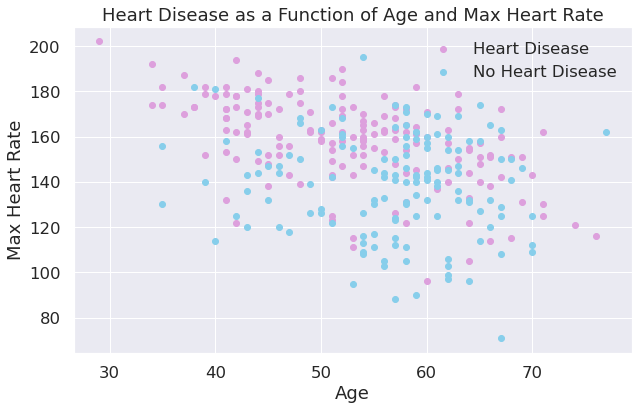

In [11]:
# Visualising Heart Disease as a Function of Age and Max Heart Rate"
plt.figure(figsize = (10,6))

plt.scatter(heart_df.age[heart_df.target == 1],
           heart_df.thalach[heart_df.target == 1],
                           c = "plum")
plt.scatter(heart_df.age[heart_df.target == 0],
           heart_df.thalach[heart_df.target == 0],
                           c = "skyblue")
plt.title("Heart Disease as a Function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")
plt.legend(["Heart Disease", "No Heart Disease"])



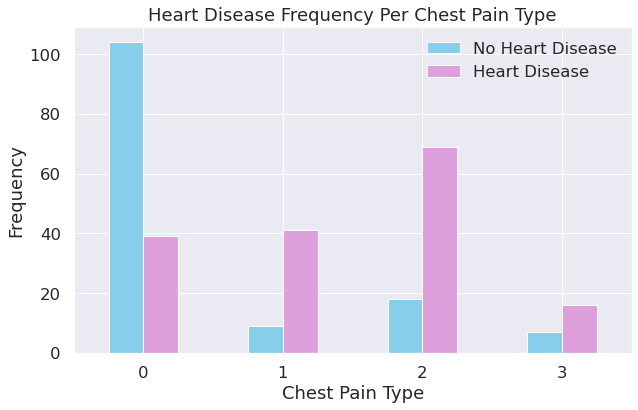

In [12]:
# Visualising Heart Disease Frequency Per Chest Pain Type
pd.crosstab(heart_df.cp,heart_df.target).plot(kind = "bar", figsize = (10, 6), color = ["skyblue", "plum"])
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Frequency")
plt.legend(["No Heart Disease", "Heart Disease"])
plt.xticks(rotation = 0);

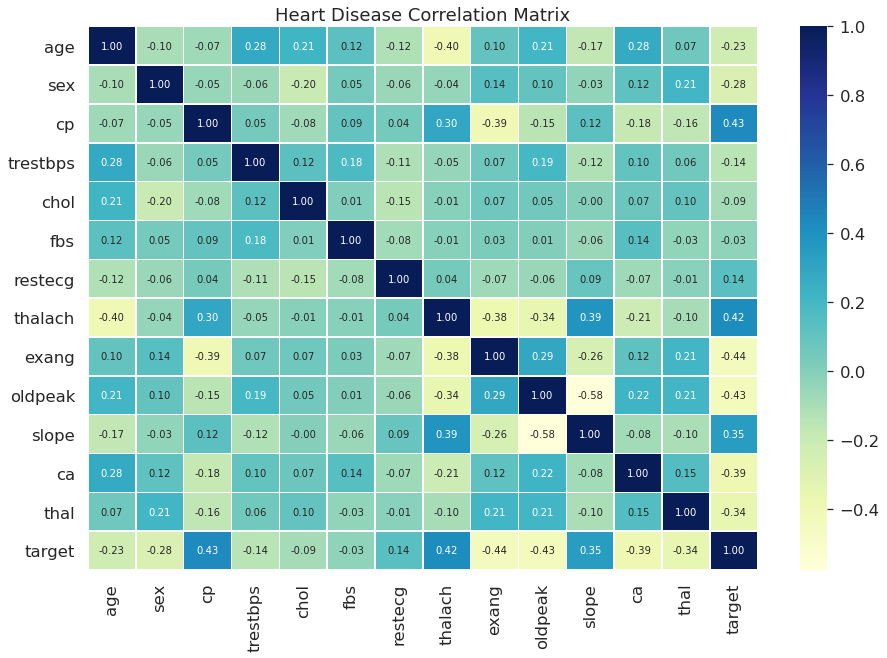

In [13]:
# Visualising Heart Disease Correlation
corr_matrix = heart_df.corr()
corr_matrix
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.heatmap(corr_matrix,
                annot = True,
                linewidth = 0.5,
                fmt = ".2f",
                cmap = "YlGnBu")
plt.title("Heart Disease Correlation Matrix");

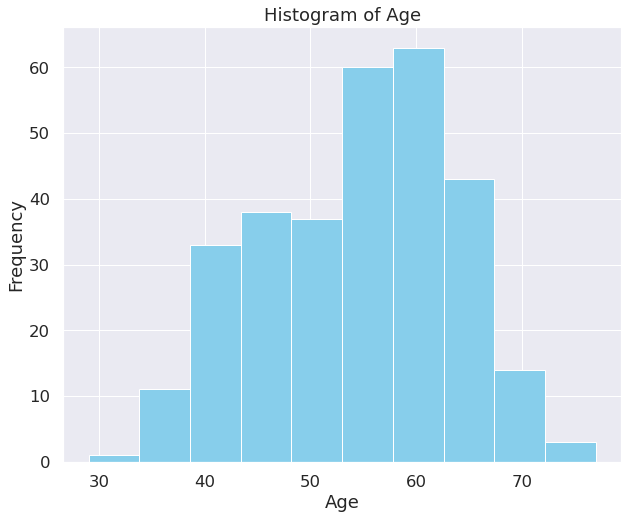

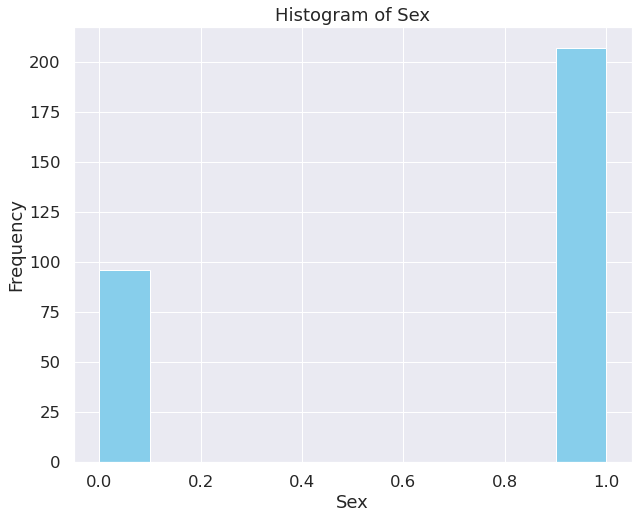

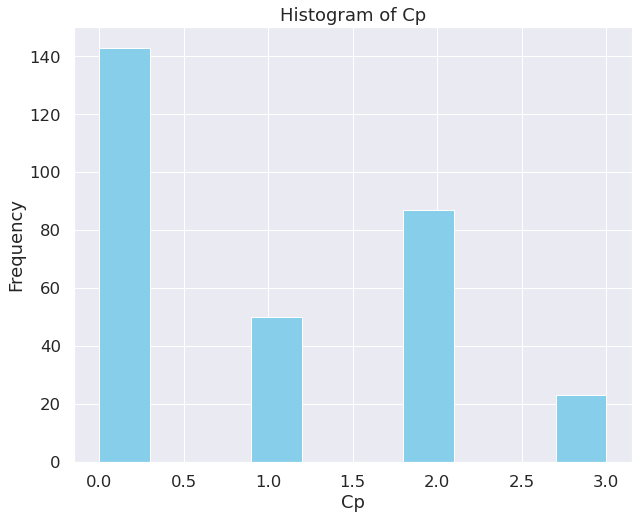

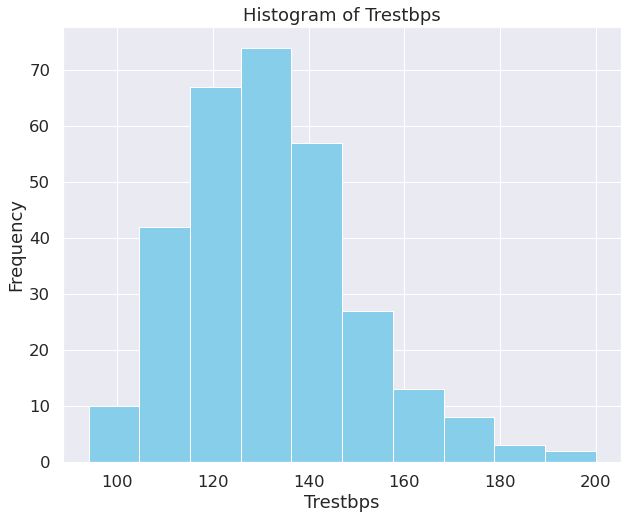

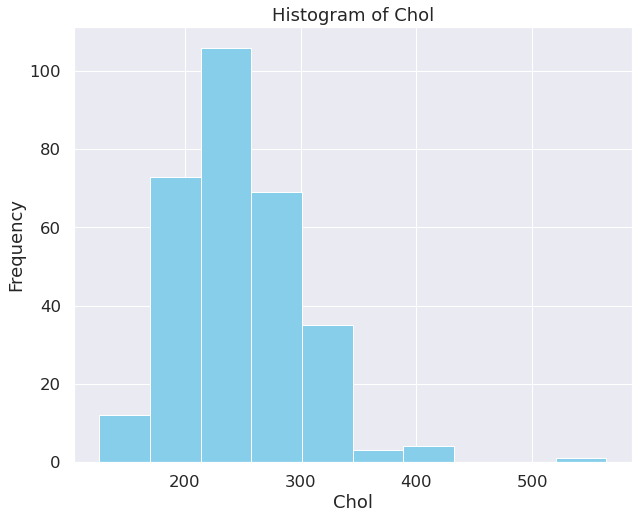

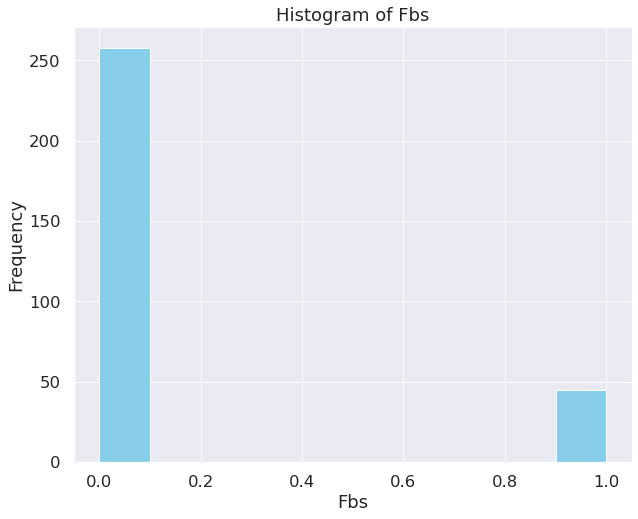

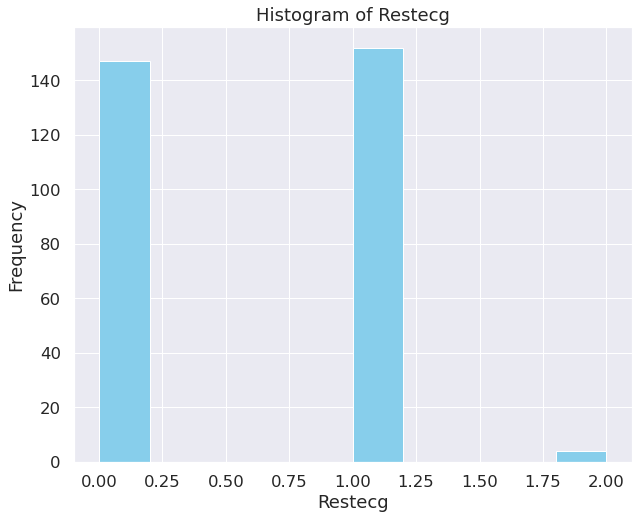

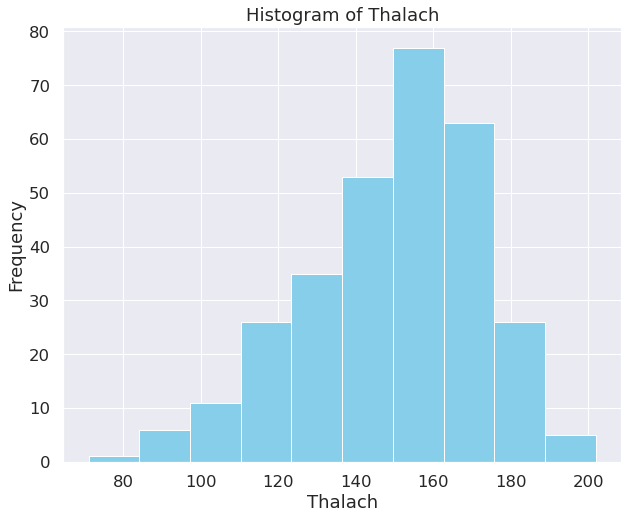

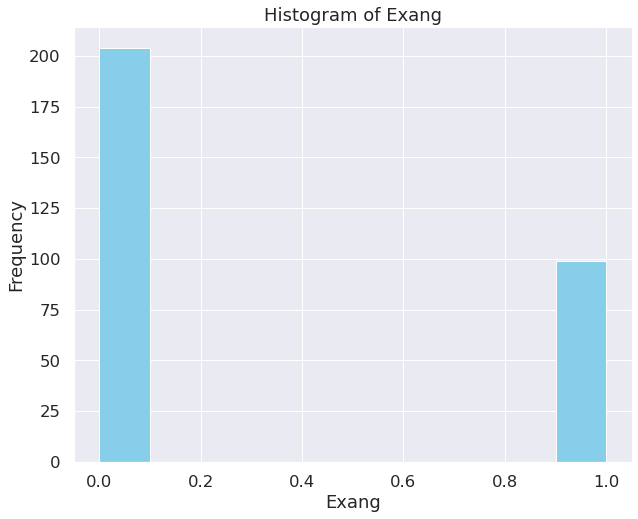

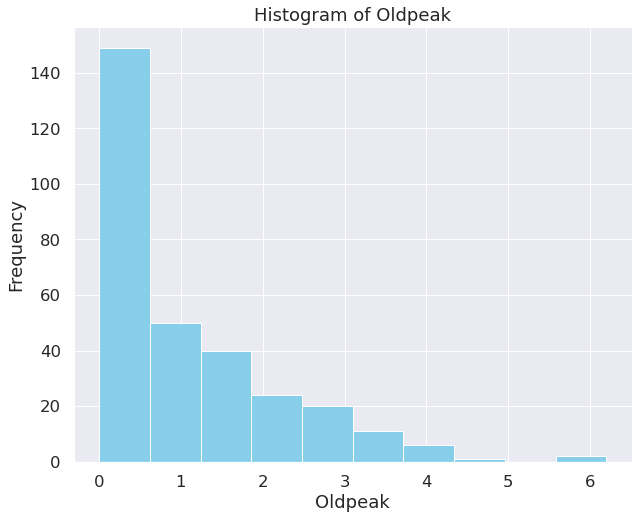

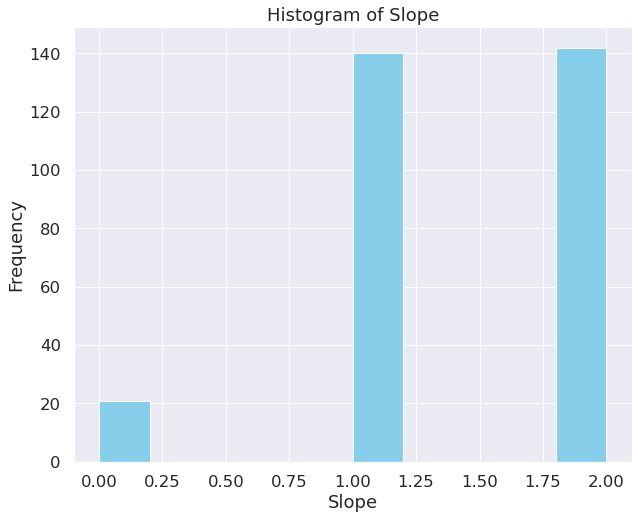

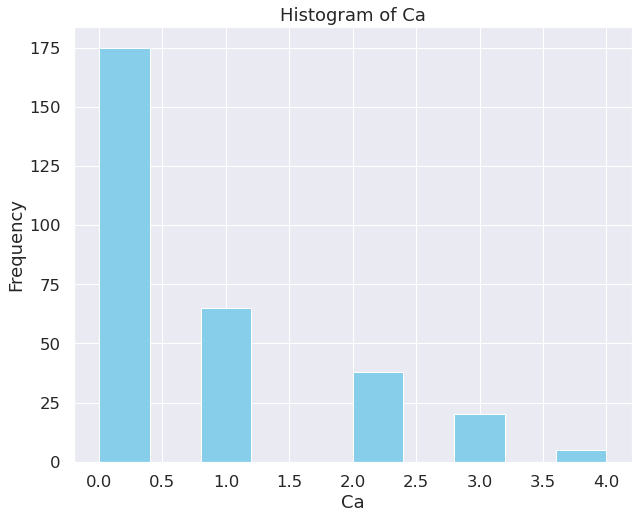

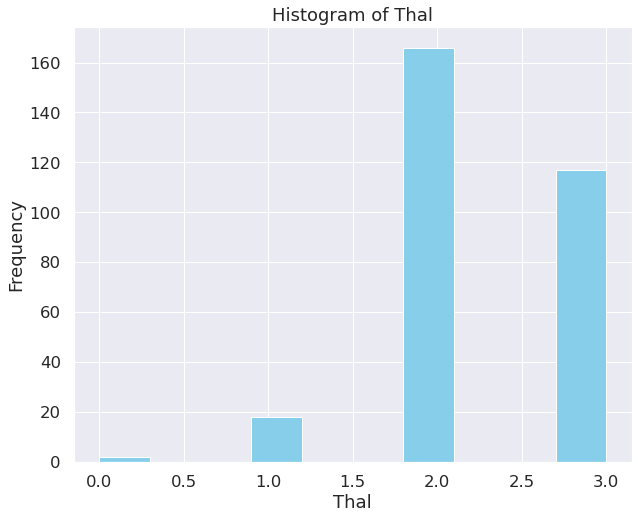

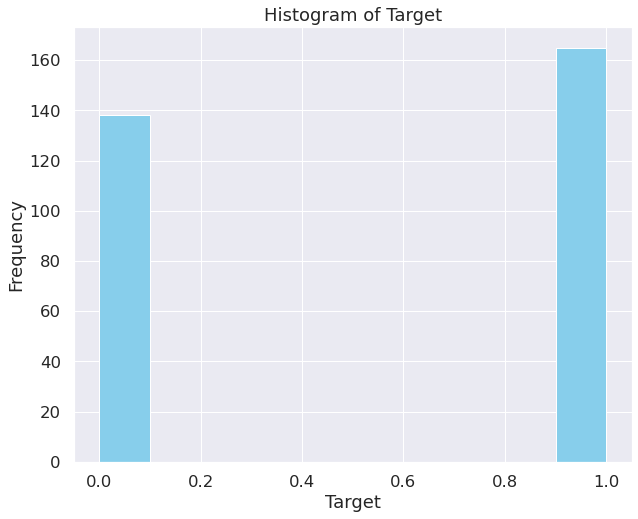

In [14]:
#Visualising the histograms of all features
feat_list = heart_df.columns.to_list()
for i in feat_list:
    heart_df[i].plot(kind = "hist", color = "skyblue", figsize = (10,8))
    plt.title(f"Histogram of {i.title()}")
    plt.xlabel(f"{i.title()}")
    plt.show()

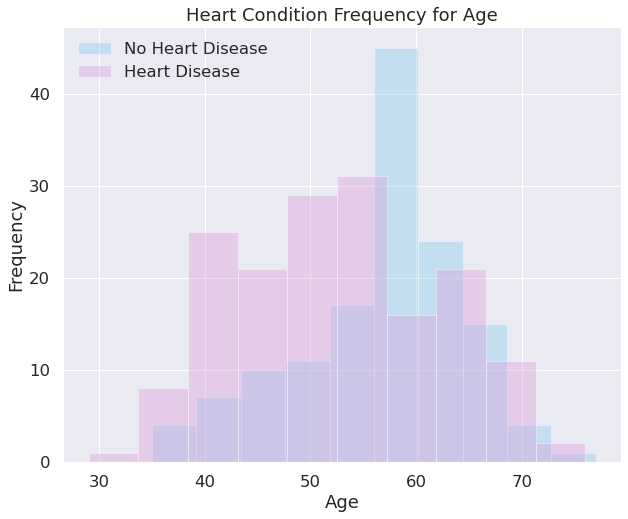

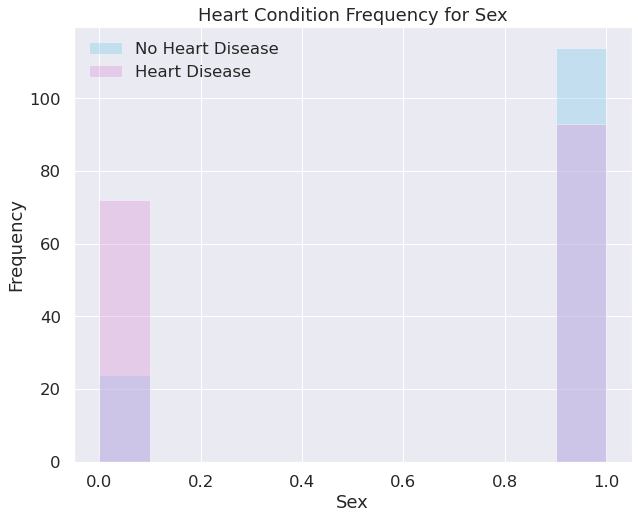

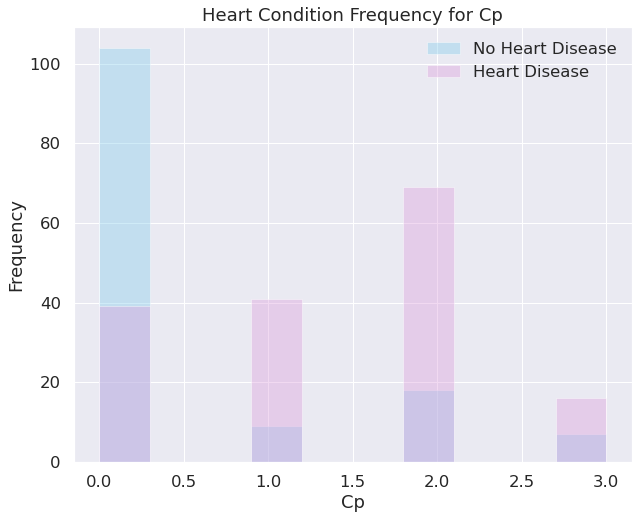

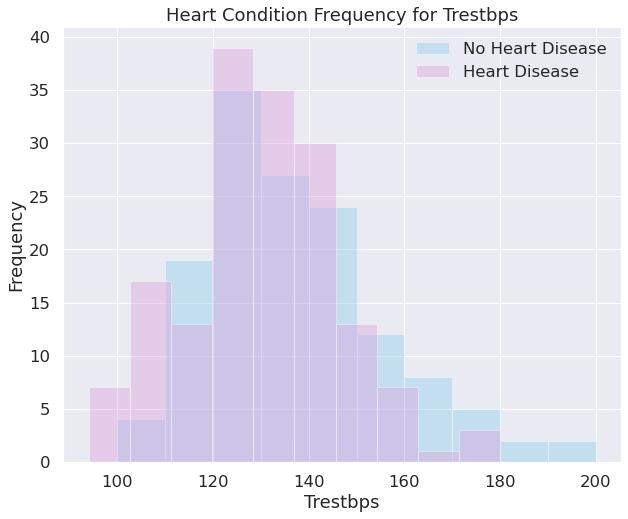

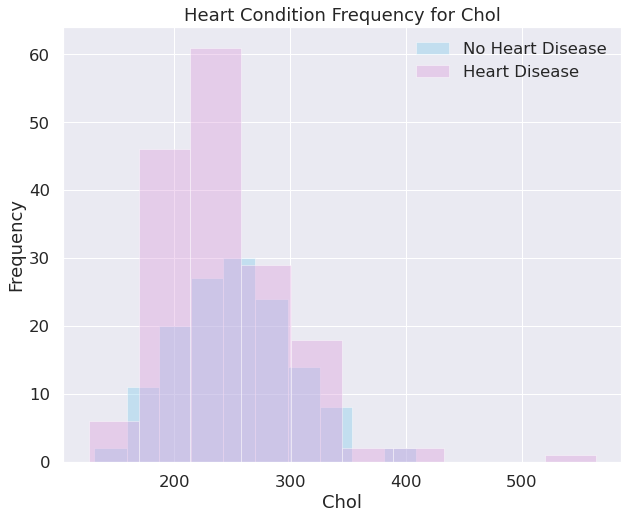

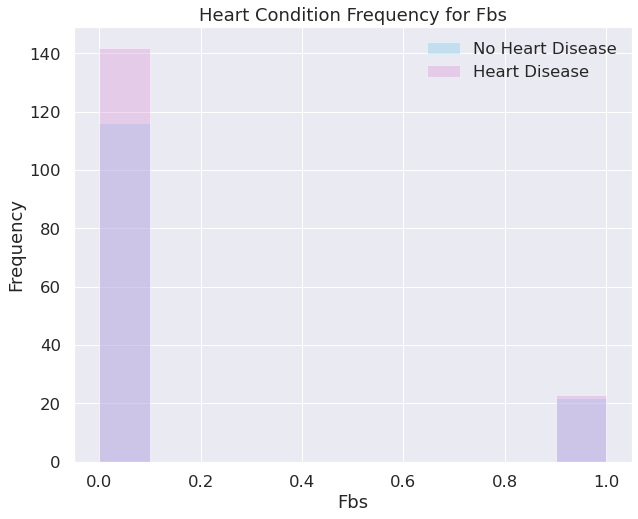

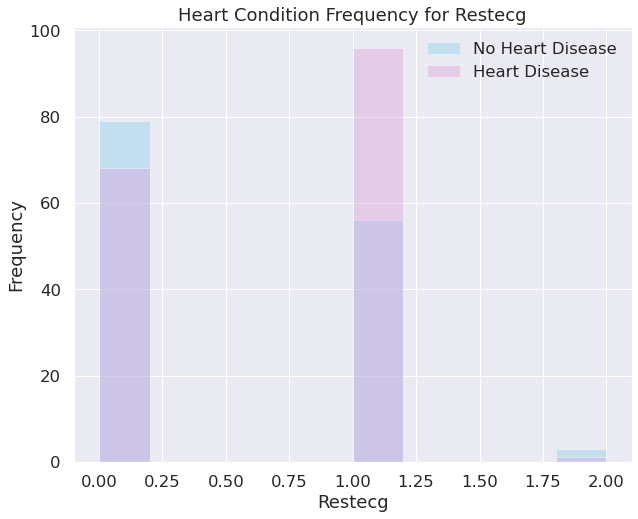

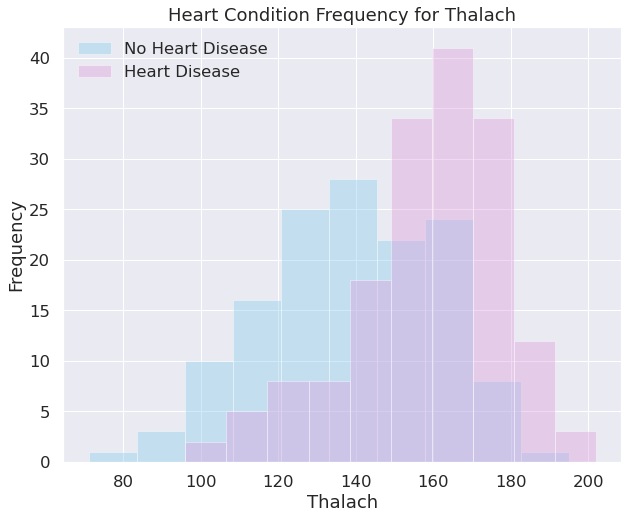

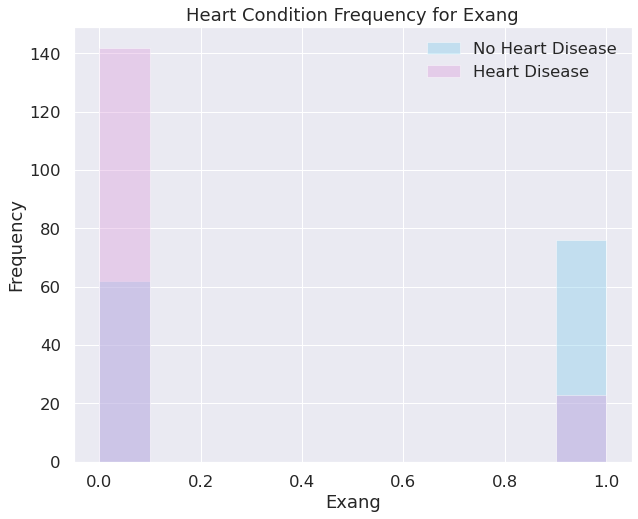

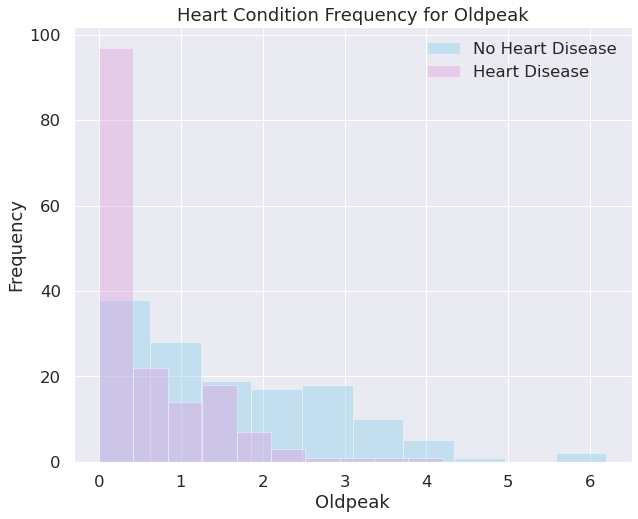

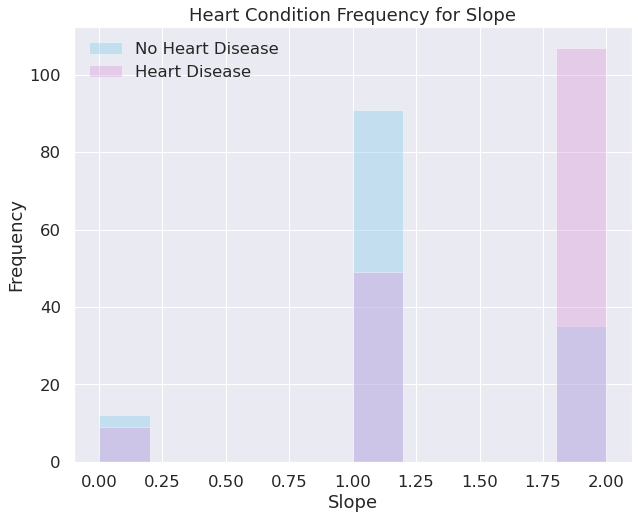

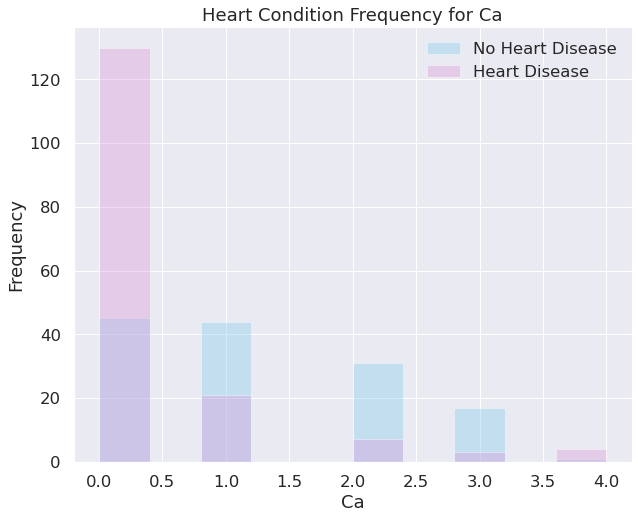

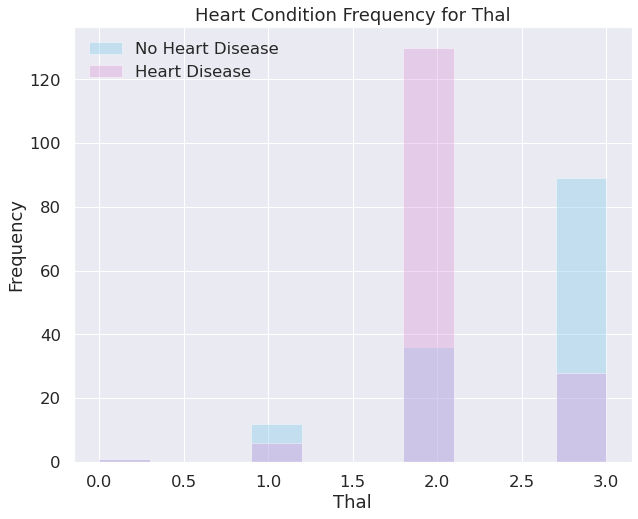

In [15]:
#Visualising the histograms of all features

feat_list = heart_df.columns.to_list()

for i in feat_list[:-1]:
    plt.figure(figsize = (10,8))
    heart_df[i][heart_df.target == 0].plot(kind = "hist", color = "skyblue", alpha = 0.4)
    heart_df[i][heart_df.target == 1].plot(kind = "hist", color = "plum", alpha = 0.4)
    plt.legend(["No Heart Disease", "Heart Disease"])
    plt.xticks(rotation = 0)
    plt.title(f"Heart Condition Frequency for {i.title()}")
    plt.xlabel(f"{i.title()}")
    plt.show()

Modelling the data

In [16]:
#Splitting the data into the features table X and the target values Y
X = heart_df.drop("target", axis = 1)
Y = heart_df.target.values

In [17]:
# Checking X
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2


In [18]:
# Checking Y
Y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
# Splitting the data into the test and train data sets, with a test size of 20%
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size = 0.2, random_state = 45)

In [20]:
# Checking the dimensions of X_train
X_train.shape

(242, 13)

In [21]:
# Checking the dimensions of Y_train
Y_train.shape

(242,)

### Models

The models that will be used on an inital run to fit and score the data:
* K-Nearest Neighbors
* Logistic Regression
* Random Forrest
* XGBoost

In [22]:
models = {"KNN" : KNeighborsClassifier(),
          "Logistic Regression" : LogisticRegression(),
          "Random Forest" : RandomForestClassifier(),
          "XGBoost" : XGBClassifier() }

def fit_and_score(models, X_train, X_test, Y_train, Y_test):
    np.random.seed(45)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, Y_train)
        model_scores[name] = model.score(X_test, Y_test)
    return model_scores

model_scores = fit_and_score(models, X_train, X_test, Y_train, Y_test)
model_scores

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'KNN': 0.6721311475409836,
 'Logistic Regression': 0.9016393442622951,
 'Random Forest': 0.8852459016393442,
 'XGBoost': 0.8032786885245902}

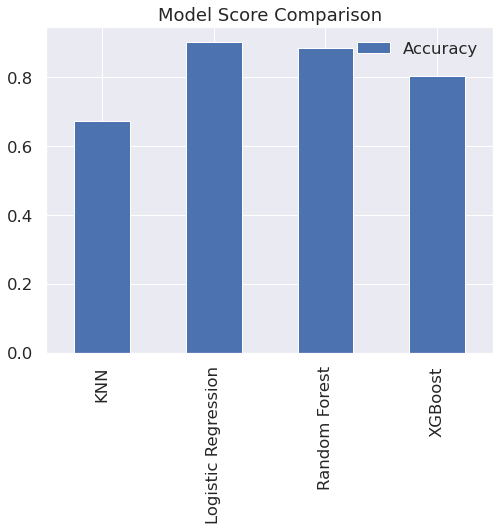

In [23]:
model_compare = pd.DataFrame(model_scores, index = ['Accuracy'])
model_compare.T.plot.bar(title = "Model Score Comparison", figsize = (8,6))

From the plot above it seems as though Logistic Regression has the best score with Random Forest coming in second.

### Tuning KNeighborClassifier

A further search into KNN's model to see if a better score can be obtained.

In [24]:
# Testing the model with different values of neighbors
train_scores = []
test_scores = []
neighbors = range(1, 21)
knn = KNeighborsClassifier()

for i in neighbors:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, Y_train)
    train_scores.append(knn.score(X_train, Y_train))
    test_scores.append(knn.score(X_test, Y_test))

Maximum score on the test data: 73.77%


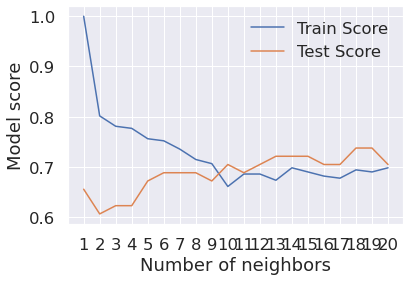

In [25]:
#Plotting KNN's training and testing scores

plt.plot(neighbors, train_scores, label = "Train Score")
plt.plot(neighbors, test_scores, label = "Test Score")
plt.xticks(np.arange(1,21,1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()
print(f"Maximum score on the test data: {max(test_scores)*100:.2f}%")

### Using RandomizedGridSearch to Tune Logistic Regression, Random Forest Classifier and XGBoost

LogisticRegression

In [26]:
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

np.random.seed(45)

rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                              param_distributions = log_reg_grid,
                              cv = 5,
                              n_iter = 20,
                              verbose = True)

rs_log_reg.fit(X_train,Y_train )
rs_log_reg.best_params_ , rs_log_reg.score(X_test, Y_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.5s finished


({'solver': 'liblinear', 'C': 0.615848211066026}, 0.9016393442622951)

RandomForest

In [27]:
rf_grid = {"n_estimators": [100,200,300,410,500],
          "max_depth": [None, 3,5,10],
          "min_samples_split": np.arange(2,20,2),
          "min_samples_leaf": np.arange(1,20,2) }

np.random.seed(45)


rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                              param_distributions = rf_grid,
                              cv = 5,
                              n_iter = 20,
                              verbose = True)

rs_rf.fit(X_train,Y_train )
rs_rf.best_params_ , rs_rf.score(X_test, Y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.0min finished


({'n_estimators': 100,
  'min_samples_split': 14,
  'min_samples_leaf': 19,
  'max_depth': 3},
 0.8688524590163934)

XGBoost

In [28]:
xgb_grid = {"n_estimators": [10, 100],
            "eta": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
          "max_depth": [None, 3,6,9,12],
          "min_samples_split": [3,6,9,12],
          "min_samples_leaf": [1,3,6,8],
            "min_child_weight":[3,5,8,10],
           "gamma":[0.0,0.1,0.2, 0.3],
            'subsample':[0.3,0.4,0.5,0.6,0.75,0.80,0.85],
            'colsample_bytree':[0.3,0.5,0.6,0.75,0.80,0.85]}

np.random.seed(45)


rs_xgb = RandomizedSearchCV(XGBClassifier(),
                              param_distributions = xgb_grid,
                              cv = 5,
                              n_iter = 200,
                              verbose = True)

rs_xgb.fit(X_train,Y_train )
rs_xgb.best_params_ , rs_xgb.score(X_test, Y_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   16.5s finished


({'subsample': 0.85,
  'n_estimators': 100,
  'min_samples_split': 3,
  'min_samples_leaf': 3,
  'min_child_weight': 8,
  'max_depth': 9,
  'gamma': 0.1,
  'eta': 0.1,
  'colsample_bytree': 0.8},
 0.8688524590163934)

From the RandomizedGridSearch we see that Logistic Regression still has the best score and while the score for XGBoost has improved, it's still less than Logistic Regression so we'll select Logistic as our model of choice and see if we can improve the score with GridSearchCV.

### Tuning With GridSearchCV

In [29]:
log_reg_grid = {"C": np.logspace(-4, 4, 40),
                "solver": ["liblinear"]}

np.random.seed(45)

gs_log_reg = GridSearchCV(LogisticRegression(),
                              param_grid = log_reg_grid,
                              cv = 5,
                              verbose = True)

gs_log_reg.fit(X_train,Y_train )
gs_log_reg.best_params_ , gs_log_reg.score(X_test, Y_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


({'C': 0.30702906297578497, 'solver': 'liblinear'}, 0.9016393442622951)

### Evaluating The Model

In [30]:
#Creating predictions for X_test
Y_preds = gs_log_reg.predict(X_test)

In [31]:
#Checking Y_preds
Y_preds

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

In [32]:
#Checking Y_test
Y_test

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

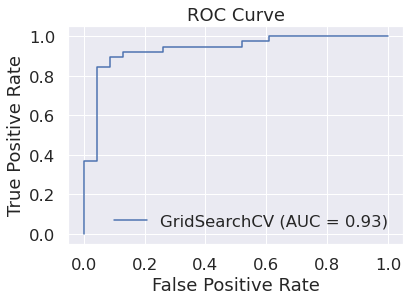

In [33]:
#Visualising th ROC curve
plot_roc_curve(gs_log_reg, X_test, Y_test)
plt.title("ROC Curve");

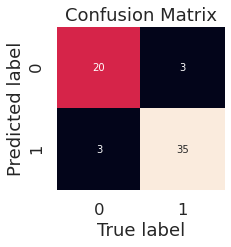

In [34]:
# Plotting the confusion matrix

def plot_conf_mat(Y_test, Y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_preds),
                    annot = True,
                    cbar = False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    
plot_conf_mat(Y_test, Y_preds)
plt.title("Confusion Matrix");

Classification Report

In [35]:
print(classification_report(Y_test, Y_preds))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.92      0.92      0.92        38

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



Cross-validated accuracy score

In [36]:
model = LogisticRegression(C = 0.30702906297578497, solver = 'liblinear')

cv_acc = np.mean(cross_val_score(model,
                        X,
                        Y,
                        cv = 5,
                        scoring = "accuracy"))
cv_acc

0.8446994535519126

> Cross-validated precision

In [37]:
cv_precision = np.mean(cross_val_score(model, X, Y, 
                                       cv = 5, scoring = "precision"))
cv_precision

0.8209150326797385

> Cross-validated recall

In [38]:
cv_recall = np.mean(cross_val_score(model, X, Y,
                                   cv = 5, scoring = "recall"))
cv_recall

0.9212121212121213

> Cross-validated F1 score

In [39]:
cv_f1 = np.mean(cross_val_score(model, X, Y,
                               cv = 5, scoring = "f1"))
cv_f1

0.867291890754684

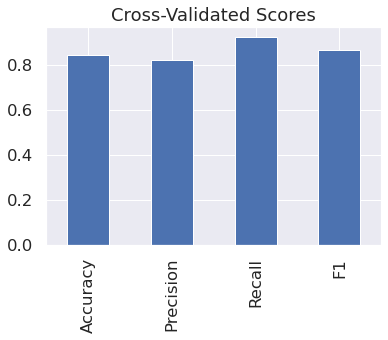

In [40]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                          "Precision": cv_precision,
                          "Recall": cv_recall,
                          "F1": cv_f1},
                         index = [0])
cv_metrics.T.plot(kind = "bar", title = "Cross-Validated Scores", legend = False)

### Feature Importance

 To obtain the feature importance for Logestic Regression we obtain the coefficients produced form fitting the model.

In [41]:
model.fit(X_train, Y_train)
model.coef_

array([[ 0.00945172, -1.12760991,  0.6793453 , -0.01407323, -0.00312478,
         0.01813068,  0.33383125,  0.02619011, -0.66462404, -0.53167518,
         0.51051747, -0.60297941, -0.62272161]])

In [42]:
# Here we pair the coefficients with their feature names

features_dict = dict(zip(heart_df.columns, list(model.coef_[0])))
features_dict

{'age': 0.009451720398729234,
 'sex': -1.1276099089241793,
 'cp': 0.6793453014238494,
 'trestbps': -0.014073227762107787,
 'chol': -0.0031247796244744065,
 'fbs': 0.018130678187735314,
 'restecg': 0.3338312537660166,
 'thalach': 0.0261901097647968,
 'exang': -0.6646240423459621,
 'oldpeak': -0.5316751822576231,
 'slope': 0.510517473586808,
 'ca': -0.6029794064935979,
 'thal': -0.6227216143085132}

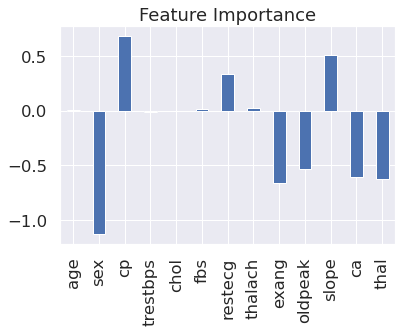

In [43]:
features_df = pd.DataFrame(features_dict, index = [0])
features_df.T.plot.bar(title = "Feature Importance", legend = False);

Since we can see that some features such as "age", "trestbps", "chol", "fbs", and "thalach" have a low feature importance, let's see if we can improve the score by removing these features.

In [44]:
#testing if removing the "age" feature would improve the score

X_red = heart_df.drop(["target", "age"], axis = 1)
Y_red = heart_df.target.values


X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split( X_red, Y_red, test_size = 0.2, random_state = 45)

log_reg_grid = {"C": np.logspace(-4, 4, 40),
                "solver": ["liblinear"]}

np.random.seed(45)

gs_log_reg = GridSearchCV(LogisticRegression(),
                              param_grid = log_reg_grid,
                              cv = 5,
                              verbose = True)

gs_log_reg.fit(X_train_red,Y_train_red )
gs_log_reg.best_params_ , gs_log_reg.score(X_test_red, Y_test_red)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


({'C': 0.49238826317067363, 'solver': 'liblinear'}, 0.8852459016393442)

In [45]:
model = LogisticRegression(C = 0.49238826317067363, solver = 'liblinear')

cv_acc = np.mean(cross_val_score(model,
                        X_red,
                        Y_red,
                        cv = 5,
                        scoring = "accuracy"))
cv_acc

0.8414207650273223

In [46]:
#testing if removing the "trestbps" features would improve the score

X_red = heart_df.drop(["target", "trestbps"], axis = 1)
Y_red = heart_df.target.values


X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split( X_red, Y_red, test_size = 0.2, random_state = 45)

log_reg_grid = {"C": np.logspace(-4, 4, 40),
                "solver": ["liblinear"]}

np.random.seed(45)

gs_log_reg = GridSearchCV(LogisticRegression(),
                              param_grid = log_reg_grid,
                              cv = 5,
                              verbose = True)

gs_log_reg.fit(X_train_red,Y_train_red )
gs_log_reg.best_params_ , gs_log_reg.score(X_test_red, Y_test_red)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


({'C': 0.49238826317067363, 'solver': 'liblinear'}, 0.8524590163934426)

In [47]:
model = LogisticRegression(C = 0.49238826317067363, solver = 'liblinear')

cv_acc = np.mean(cross_val_score(model,
                        X_red,
                        Y_red,
                        cv = 5,
                        scoring = "accuracy"))
cv_acc

0.8414754098360657

In [48]:
#testing if removing the "chol" feature would improve the score

X_red = heart_df.drop(["target", "chol"], axis = 1)
Y_red = heart_df.target.values


X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split( X_red, Y_red, test_size = 0.2, random_state = 45)

log_reg_grid = {"C": np.logspace(-4, 4, 40),
                "solver": ["liblinear"]}

np.random.seed(45)

gs_log_reg = GridSearchCV(LogisticRegression(),
                              param_grid = log_reg_grid,
                              cv = 5,
                              verbose = True)

gs_log_reg.fit(X_train_red,Y_train_red )
gs_log_reg.best_params_ , gs_log_reg.score(X_test_red, Y_test_red)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


({'C': 0.7896522868499725, 'solver': 'liblinear'}, 0.8688524590163934)

In [49]:
model = LogisticRegression(C = 0.7896522868499725, solver = 'liblinear')

cv_acc = np.mean(cross_val_score(model,
                        X_red,
                        Y_red,
                        cv = 5,
                        scoring = "accuracy"))
cv_acc

0.8314207650273223

In [50]:
#testing if removing the "age", "trestbps", "chol", "fbs", and "thalach" features would improve the score

X_red = heart_df.drop(["target","age", "trestbps", "chol", "fbs", "thalach"], axis = 1)
Y_red = heart_df.target.values


X_train_red, X_test_red, Y_train_red, Y_test_red = train_test_split( X_red, Y_red, test_size = 0.2, random_state = 45)

log_reg_grid = {"C": np.logspace(-4, 4, 40),
                "solver": ["liblinear"]}

np.random.seed(45)

gs_log_reg = GridSearchCV(LogisticRegression(),
                              param_grid = log_reg_grid,
                              cv = 5,
                              verbose = True)

gs_log_reg.fit(X_train_red,Y_train_red )
gs_log_reg.best_params_ , gs_log_reg.score(X_test_red, Y_test_red)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


({'C': 0.49238826317067363, 'solver': 'liblinear'}, 0.819672131147541)

In [51]:
model = LogisticRegression(C = 0.49238826317067363, solver = 'liblinear')

cv_acc = np.mean(cross_val_score(model,
                        X_red,
                        Y_red,
                        cv = 5,
                        scoring = "accuracy"))
cv_acc

0.828087431693989

## Conclusion

By using Logistic Regression with C = 0.30702906297578497 and using the solver 'liblinear', 
a cross-validated accuracy score of 0.8446994535519126, precision of 0.8209150326797385, 
recall of 0.9212121212121213, and an f1 score of 0.867291890754684 was able to be obtained.

While there were features that had a low feature importance, removing these features did not 
improve the cross-validated scores.


This project has been created as part of the classwork for the ZTM Machine Learning Course
